# Conclusiones finales — Análisis hidráulico y modelos de detección/predicción (Δt ≈ 1 min)

**Proyecto:** ESVAL — transientes operacionales, aperturas/cierres y aprendizaje supervisado  
**Fecha:** 2025-12-23  

> Documento dirigido al profesor.  
> Consolida lo realizado en los notebooks 02–05 y entrega una lectura física + selección de modelos ML.

---

## Índice
1. Contexto, datos y supuestos
2. Definiciones hidráulicas (magnitudes derivadas)
3. Resumen de lo realizado (02–05)
4. Interpretación física de aperturas y cierres (frecuencia y severidad)
5. Anomalías (Isolation Forest)
6. Modelos supervisados: resultados, gráficos y modelo recomendado
7. Limitaciones y recomendaciones
8. Conclusiones finales


In [8]:
# Setup y lectura de artefactos
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = Path("/home/maxi/datascience_esval")
DATA = PROJECT_ROOT / "data" / "processed"

SENS_FILE   = DATA / "sensores_1min_clean.parquet"
EVENTS_FILE = DATA / "eventos_apertura_cierre.parquet"
HORIZ_FILE  = DATA / "eventos_apertura_cierre_horizontes.parquet"

IF_LABELED  = DATA / "eventos_iforest_labeled.parquet"
IF_ANOMS    = DATA / "iforest_anomalias.parquet"

ML_REPORT   = DATA / "ml_report_metrics.parquet"
ML_SENSIT   = DATA / "ml_sensitivity_budgets.parquet"

def read_if_exists(p: Path):
    return pd.read_parquet(p) if p.exists() else None

sens   = read_if_exists(SENS_FILE)
events = read_if_exists(EVENTS_FILE)
horiz  = read_if_exists(HORIZ_FILE)
if_lab = read_if_exists(IF_LABELED)
if_an  = read_if_exists(IF_ANOMS)
ml_rep = read_if_exists(ML_REPORT)
ml_sen = read_if_exists(ML_SENSIT)

{ "sens": sens is not None, "events": events is not None, "horiz": horiz is not None,
  "ml_rep": ml_rep is not None, "ml_sen": ml_sen is not None }


{'sens': True, 'events': True, 'horiz': True, 'ml_rep': True, 'ml_sen': True}

## 1) Contexto, datos y supuestos

### Datos
- Serie temporal muestreada a **1 minuto** (aprox.).
- Variables medidas:
  - Caudal: $Q(t)$ en **L/s**.
  - Presión: $P_g(t)$ en **bar** (**presión manométrica / gauge**).

### Geometría disponible
- Diámetro interno nominal: $D = 0.315~\mathrm{m}$ (DN315).
- Área: $$A=\frac{\pi D^2}{4}.$$

### Parámetros de referencia
- Densidad: $\rho \approx 1000~\mathrm{kg/m^3}$.
- Presión atmosférica: $P_{\mathrm{atm}} \approx 1.01325~\mathrm{bar}$ (ajustable por altitud).
- Temperatura de referencia: $T \approx 20^\circ\mathrm{C}$.
- Presión de vapor (agua a $20^\circ\mathrm{C}$): $P_v \approx 0.0233~\mathrm{bar}$.

> Nota clave: con $\Delta t\approx 1$ min **no** se observa el pico instantáneo de un transiente clásico (segundos).  
> Por ello, el “golpe de ariete” se interpreta aquí como **proxy a escala minuto**: cambios netos, persistencia y severidad relativa.


In [9]:
# Parámetros numéricos usados (consistentes con los notebooks previos)
D = 0.315
A = np.pi * D**2 / 4
rho = 1000.0
P_atm_bar = 1.01325
Pv_bar = 0.023295689144226493

A


0.07793113276311181

## 2) Definiciones hidráulicas (magnitudes derivadas)

### 2.1 Velocidad media
Con $Q(t)$ en $\mathrm{m^3/s}$ (conversión desde L/s):
$$Q_{m^3/s}(t)=10^{-3}\,Q_{L/s}(t),\qquad
V(t)=\frac{Q_{m^3/s}(t)}{A}.$$

### 2.2 Presión absoluta
El sensor mide presión manométrica:
$$P_{\mathrm{abs}}(t)\approx P_g(t)+P_{\mathrm{atm}}.$$

### 2.3 Cavitación (screening termodinámico)
Criterio básico:
$$P_{\mathrm{abs}}(t)<P_v(T).$$

Número de cavitación:
$$\sigma(t)=\frac{P_{\mathrm{abs}}(t)-P_v(T)}{\tfrac{1}{2}\rho V(t)^2}.$$

Valores bajos de $\sigma$ sugieren susceptibilidad a cavitación **local** (especialmente cerca de singularidades),
aunque el criterio termodinámico se evalúe en el punto de sensor.


In [10]:
# Identificación robusta de columnas y cálculo de magnitudes (si hay sensores)
def pick_col(cols, keys):
    for k in keys:
        for c in cols:
            if k in c.lower():
                return c
    return None

if sens is not None:
    if not isinstance(sens.index, pd.DatetimeIndex):
        time_candidates = [c for c in sens.columns if ("fecha" in c.lower()) or ("time" in c.lower()) or ("hora" in c.lower())]
        if time_candidates:
            tcol = time_candidates[0]
            sens[tcol] = pd.to_datetime(sens[tcol])
            sens = sens.set_index(tcol)
    sens = sens.sort_index()

    Q_COL = next((c for c in sens.columns if c.lower() == "q_lps"), None) or pick_col(sens.columns, ["q_lps","caudal","flow"])
    P_COL = next((c for c in sens.columns if c.lower() == "p_bar"), None) or pick_col(sens.columns, ["p_bar","pres","pe_","booster"])

    df = sens[[Q_COL, P_COL]].rename(columns={Q_COL:"Q_lps", P_COL:"P_g_bar"}).copy()
    df = df.replace([np.inf, -np.inf], np.nan)

    df["Q_m3s"] = 1e-3 * df["Q_lps"]
    df["V_ms"]  = df["Q_m3s"] / A
    df["P_abs_bar"] = df["P_g_bar"] + P_atm_bar
    df["margin_vap_bar"] = df["P_abs_bar"] - Pv_bar

    dyn_bar = 0.5 * rho * (df["V_ms"]**2) / 1e5  # Pa -> bar
    df["sigma_cav"] = df["margin_vap_bar"] / dyn_bar

    df["dP_1min_bar"] = df["P_g_bar"].diff()
    df["dQ_1min_lps"] = df["Q_lps"].diff()
    df["dV_1min_ms"]  = df["V_ms"].diff()

    summary = {
        "rango": (str(df.index.min()), str(df.index.max())),
        "frac_valid_QP": float(df[["Q_lps","P_g_bar"]].notna().all(axis=1).mean()),
        "min_P_g_bar": float(df["P_g_bar"].min(skipna=True)),
        "min_P_abs_bar": float(df["P_abs_bar"].min(skipna=True)),
        "frac_Pabs_lt_Pv": float((df["P_abs_bar"] < Pv_bar).mean()),
        "V_ms_q": df["V_ms"].dropna().quantile([0.01,0.5,0.99]).to_dict(),
        "|dP|_q": df["dP_1min_bar"].abs().dropna().quantile([0.5,0.95,0.99,0.999]).to_dict(),
    }
    summary
else:
    "sensores no disponibles"


## 3) Resumen de lo realizado (02–05)

### Notebook 02 — Variables hidráulicas y screening
- Conversión geométrica ($D$, $A$) y cálculo de $V(t)$.
- Conversión $P_g \to P_{\mathrm{abs}}$.
- Screening termodinámico de cavitación $P_{\mathrm{abs}}<P_v$ y cálculo de $\sigma$.
- Proxies de transiente a 1-min: $|\Delta V|$, $|\Delta P|$.

**Conclusión de screening:** no se observó $P_{\mathrm{abs}}<P_v$ en el sensor; esto reduce evidencia directa de cavitación en ese punto,
pero no descarta mínimos locales fuera del sensor ni mínimos instantáneos submuestreados.

---

### Notebook 03 — Detección y segmentación de eventos (apertura/cierre)
- Detección basada en escalones de caudal y persistencia.
- Separación por tipo: **apertura** ($\Delta Q>0$) y **cierre** ($\Delta Q<0$).
- Caracterización temporal por bins de 4 min: subida/bajada (0–4, 4–8, 8–12, 12–16, 16+)
  y duración total.

---

### Notebook 04 — Interpretación física y anomalías (Isolation Forest)
- Métricas a 4 y 16 min respecto a baseline (magnitudes y persistencia).
- Agrupación en familias (pulso / persistente / intermedio).
- Isolation Forest por subconjuntos homogéneos para detectar eventos atípicos.

---

### Notebook 05 — ML supervisado (detección y forecast)
- Targets:
  - Detección “start” (con ventana para aperturas: *start_win*).
  - Forecast: probabilidad de inicio brusco dentro de $K\in\{10,30,60\}$ min.
- Features sin leakage (solo historia): deltas 1-min, rolling 5/15/60, calendario seno/coseno.
- Modelos: Regresión logística (interpretabilidad) y HistGradientBoosting (no lineal).
- Evaluación por minuto (PR-AUC) y por evento (hit en ventana + presupuesto de alarmas/día).


## 4) Interpretación física de aperturas y cierres (frecuencia y severidad)

### 4.1 Lectura física a escala minuto
A escala 1-min, los eventos detectados representan cambios netos de demanda y/o maniobras en la red:

- **Apertura:** aumento de $Q$ (consumo inicia o aumenta).
- **Cierre:** disminución de $Q$ (consumo termina o se reduce).

En régimen cuasi-estacionario, la presión responde principalmente por pérdidas (dependen de $V^2$).
Cuando el cambio es rápido, aparecen firmas de transiente.

### 4.2 Golpe de ariete (lectura conservadora)
La relación de Joukowsky:
$$\Delta P \approx \rho\,a\,\Delta V,$$
es un límite ideal para cierres rápidos (en escala de segundos). Con $\Delta t\approx 1$ min no se captura el pico,
por lo que se usa como guía cualitativa: cambios mayores de $|\Delta V|$ tienden a asociarse a $|\Delta P|$ mayores,
si el sistema se acerca a un cierre rápido.

### 4.3 Gráficos: frecuencia mensual de aperturas/cierres bruscos
Se grafican conteos mensuales usando la definición operacional de “brusco” disponible en el dataset de eventos
(por ejemplo, bin de subida/bajada 0–4 min).


In [11]:
# Preparación de 'is_brusco' y agregación por mes (requiere events)
if events is None:
    raise ValueError("No se encuentra EVENTS_FILE (eventos_apertura_cierre.parquet).")

ev = events.copy()
ev["start"] = pd.to_datetime(ev["start"])
ev = ev.sort_values("start")

# Definir brusquedad según columna disponible
if "rise_bin_4min" in ev.columns:
    ev["is_brusco"] = (ev["rise_bin_4min"].astype(str) == "0-4")
elif "rise_time_min" in ev.columns:
    ev["is_brusco"] = (ev["rise_time_min"] <= 1)
elif "max_abs_dQ_1min_lps" in ev.columns:
    ev["is_brusco"] = (ev["max_abs_dQ_1min_lps"] >= 16)
else:
    ev["is_brusco"] = False

ev["month"] = ev["start"].dt.to_period("M").astype(str)

# Conteos por mes y tipo
monthly = (ev.groupby(["month","type","is_brusco"])
           .size()
           .rename("n")
           .reset_index())

monthly.head()


,month,type,is_brusco,n
0,2025-01,apertura,False,17
1,2025-01,apertura,True,115
2,2025-01,cierre,False,7
3,2025-01,cierre,True,130
4,2025-02,apertura,False,16


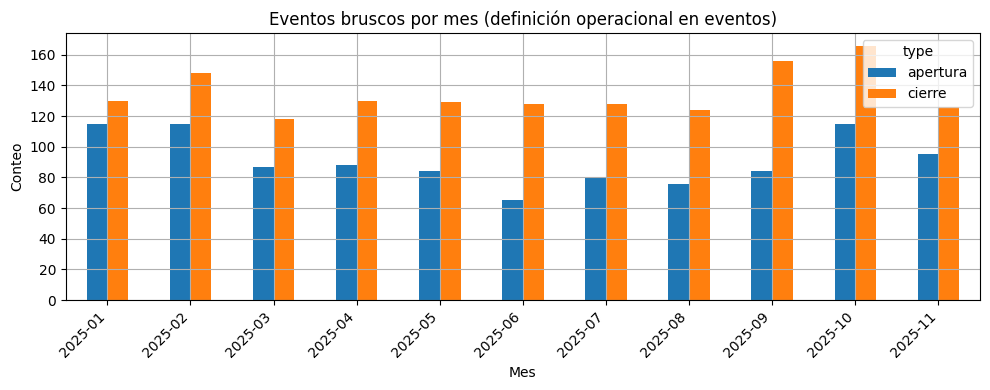

type,apertura,cierre
month,,
2025-07,80,128
2025-08,76,124
2025-09,84,156
2025-10,115,166
2025-11,95,126


In [12]:
# Plot: aperturas/cierres bruscos por mes
def plot_monthly_brusco(monthly_df):
    pivot = (monthly_df[monthly_df["is_brusco"]==True]
             .pivot_table(index="month", columns="type", values="n", aggfunc="sum")
             .fillna(0)
             .sort_index())
    ax = pivot.plot(kind="bar", stacked=False)
    ax.set_title("Eventos bruscos por mes (definición operacional en eventos)")
    ax.set_xlabel("Mes")
    ax.set_ylabel("Conteo")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return pivot

pivot_brusco = plot_monthly_brusco(monthly)
pivot_brusco.tail()


### 4.4 Gráfico: perfiles horarios (distribución relativa)
Se muestra la fracción de eventos por hora del día, separando aperturas y cierres.

> Corrección técnica: se evita el patrón `groupby(...).apply(...).reset_index()` que puede colisionar nombres de columnas.


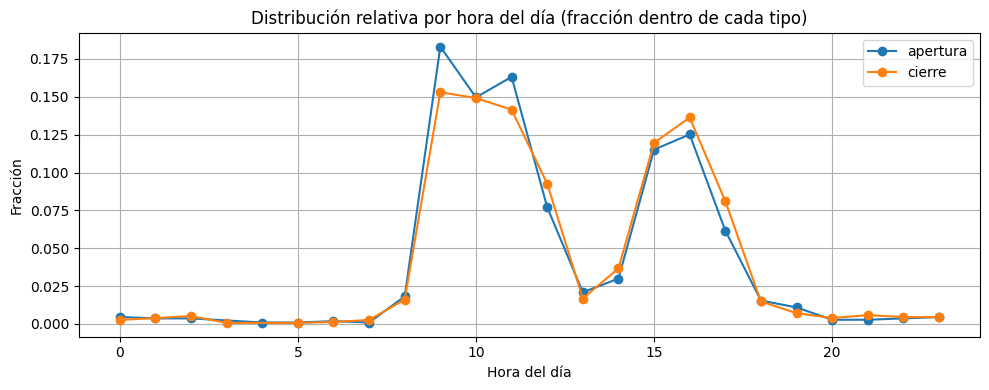

,type,hour,n,frac
0,apertura,0,5,0.004533
1,apertura,1,4,0.003626
2,apertura,2,4,0.003626
3,apertura,4,1,0.000907
4,apertura,5,1,0.000907


In [13]:
# Distribución por hora (fracción dentro de cada tipo) — versión robusta
ev2 = ev.copy()
ev2["hour"] = ev2["start"].dt.hour

counts = ev2.groupby(["type","hour"]).size().rename("n").reset_index()
counts["frac"] = counts["n"] / counts.groupby("type")["n"].transform("sum")

# Plot
for typ in sorted(counts["type"].unique()):
    s = counts[counts["type"]==typ].sort_values("hour")
    plt.plot(s["hour"], s["frac"], marker="o", label=str(typ))
plt.title("Distribución relativa por hora del día (fracción dentro de cada tipo)")
plt.xlabel("Hora del día")
plt.ylabel("Fracción")
plt.legend()
plt.tight_layout()
plt.show()

counts.head()


## 5) Anomalías (Isolation Forest): lectura física

Isolation Forest se usó para priorizar eventos atípicos respecto a la nube principal (por tipo/familia).
Un “anómalo” es un candidato a revisión operacional (maniobra, simultaneidad de consumos, condición inusual del sistema)
y no equivale necesariamente a falla.

Se listan los eventos con menor `if_score` si el archivo está disponible.


In [14]:
# Top anómalos (si existe IF_ANOMS)
if if_an is not None:
    cols = [c for c in ["type","family","start","duration_min","abs_dQ4","abs_dP4","abs_dQ16","abs_dP16","R_persist","a_app_4_ms","if_score"] if c in if_an.columns]
    top12 = if_an.sort_values("if_score", ascending=True).head(12)[cols]
    top12
else:
    "IF_ANOMS no disponible (omitido)"


## 6) Modelos supervisados: resultados, gráficos y modelo recomendado

### 6.1 Qué se modeló
Se reportaron dos tareas:

**(A) Detección (start):** alarma en el minuto de inicio (con tolerancia $\pm 1$ min).  
**(B) Forecast:** alarma si ocurre un inicio brusco dentro de $(t,t+K]$, con $K\in\{10,30,60\}$.

### 6.2 Métricas
- Por minuto: PR-AUC (Average Precision).
- Por evento:
  - *start:* hit si existe alarma en $[t_0-1, t_0+1]$.
  - *forecast:* hit si existe alarma en $[t_0-K, t_0-1]$.
- Política operacional:
  - *start:* seleccionar umbral con presupuesto de falsas alarmas por día (FP/day).
  - *forecast:* seleccionar umbral con presupuesto de alarmas por día.

### 6.3 Gráficos solicitados
1) Comparación de modelos (por target): **event_recall** vs **alertas/día** (bajo política).  
2) Curvas de sensibilidad (trade-off) usando `ml_sensitivity_budgets.parquet` para targets clave.


In [15]:
# Cargar reporte ML y seleccionar 'mejor' por target (si existe)
if ml_rep is None:
    raise ValueError("No se encuentra ML_REPORT (ml_report_metrics.parquet).")

rep = ml_rep.copy()

# Normalizar nombres esperados
# (en runs previos existen columnas como: task, target, model, policy_met, alerts_per_day, FP_per_day, event_recall, AP(PR-AUC))
needed = ["task","target","model","event_recall","alerts_per_day","AP(PR-AUC)","policy_met"]
missing = [c for c in needed if c not in rep.columns]
if missing:
    raise ValueError(f"Faltan columnas en ML_REPORT: {missing}")

best = (rep[rep["policy_met"]==True]
        .sort_values(["task","target","event_recall","AP(PR-AUC)"], ascending=[True, True, False, False])
        .groupby(["task","target"], as_index=False)
        .head(1)
        .reset_index(drop=True))

best.head(10)


,task,target,starts_key,model,AP(PR-AUC),prevalence_test,lift_AP_vs_prev,thr,policy_met,FP_per_day,alerts_per_day,n_alerts,precision_alerts,n_events_test,event_hits,event_recall,K_min,lead_med_min,lead_p10_min,lead_p90_min
0,forecast,y_close_brusco_next10,close_bru,logreg,0.365955,0.036994,9.892310,0.874504,True,NaN,42.245614,2408,NaN,292,276,0.945205,10.0,5.0,2.0,9.0
1,forecast,y_close_brusco_next30,close_bru,logreg,0.443402,0.102532,4.324510,0.913835,True,NaN,42.245614,2408,NaN,292,265,0.907534,30.0,6.0,3.0,28.0
2,forecast,y_close_brusco_next60,close_bru,logreg,0.586458,0.173518,3.379810,0.938372,True,NaN,42.245614,2408,NaN,292,220,0.753425,60.0,30.0,3.0,60.0
3,forecast,y_open_brusco_next10,open_bru,hgb,0.169779,0.031171,5.446674,0.260104,True,NaN,42.245614,2408,NaN,210,74,0.352381,10.0,10.0,2.3,10.0
4,forecast,y_open_brusco_next30,open_bru,hgb,0.364528,0.077042,4.731580,0.342126,True,NaN,42.245614,2408,NaN,210,106,0.504762,30.0,23.0,4.0,30.0
5,forecast,y_open_brusco_next60,open_bru,hgb,0.514139,0.132073,3.892838,0.478085,True,NaN,42.245614,2408,NaN,210,103,0.490476,60.0,48.0,14.0,60.0
6,start,y_close_brusco_start,close_bru,hgb,0.345229,0.003778,91.370940,0.671187,True,6.947368,13.561404,773,0.487710,292,220,0.753425,NaN,NaN,NaN,NaN
7,start,y_close_start,close_all,hgb,0.352762,0.003921,89.975227,0.666651,True,6.701754,13.350877,761,0.498029,303,223,0.735974,NaN,NaN,NaN,NaN
8,start,y_open_brusco_start_win,open_bru,logreg,0.160075,0.008113,19.730531,0.897953,True,9.210526,12.315789,702,0.252137,210,170,0.809524,NaN,NaN,NaN,NaN
9,start,y_open_start_win,open_all,hgb,0.182125,0.008346,21.821908,0.300829,True,10.192982,13.561404,773,0.248383,216,175,0.810185,NaN,NaN,NaN,NaN


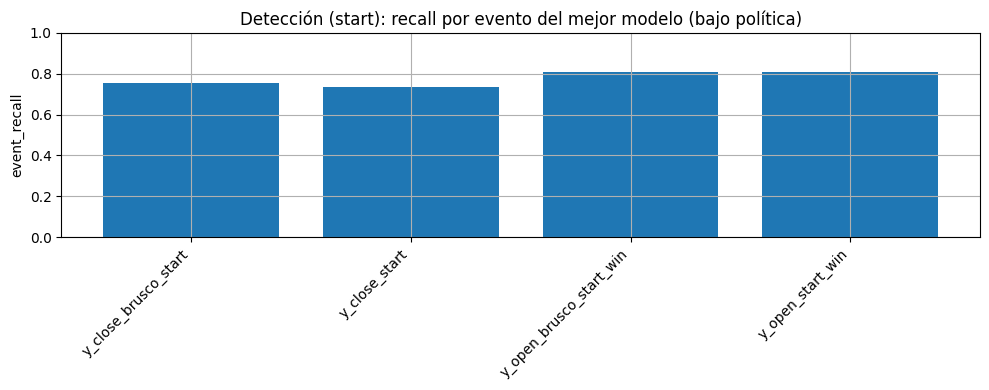

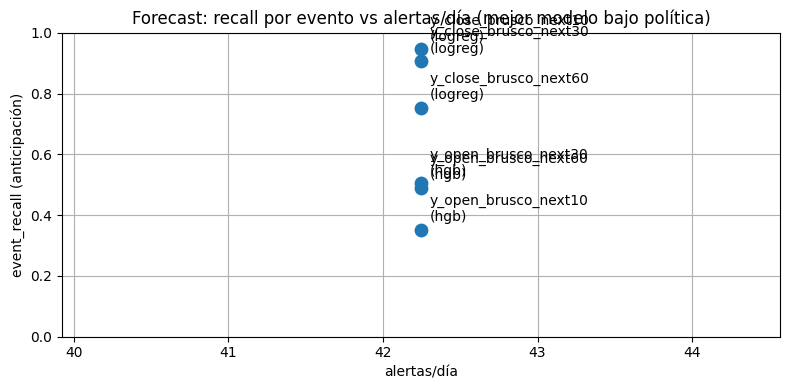

,task,target,model,event_recall,alerts_per_day,AP(PR-AUC)
0,forecast,y_close_brusco_next10,logreg,0.945205,42.245614,0.365955
1,forecast,y_close_brusco_next30,logreg,0.907534,42.245614,0.443402
2,forecast,y_close_brusco_next60,logreg,0.753425,42.245614,0.586458
4,forecast,y_open_brusco_next30,hgb,0.504762,42.245614,0.364528
5,forecast,y_open_brusco_next60,hgb,0.490476,42.245614,0.514139
3,forecast,y_open_brusco_next10,hgb,0.352381,42.245614,0.169779
9,start,y_open_start_win,hgb,0.810185,13.561404,0.182125
8,start,y_open_brusco_start_win,logreg,0.809524,12.315789,0.160075
6,start,y_close_brusco_start,hgb,0.753425,13.561404,0.345229
7,start,y_close_start,hgb,0.735974,13.350877,0.352762


In [16]:
# Plot: desempeño por target (event_recall y alertas/día) para el mejor modelo bajo política
# Nota: en targets 'start' existe también FP/day; en forecast se usa alertas/día.
plot_df = best.copy()

# separar
start_df = plot_df[plot_df["task"]=="start"].copy()
fcst_df  = plot_df[plot_df["task"]=="forecast"].copy()

# (A) Start: barras de event_recall
if len(start_df):
    plt.figure(figsize=(10,4))
    x = np.arange(len(start_df))
    plt.bar(x, start_df["event_recall"].values)
    plt.xticks(x, start_df["target"].values, rotation=45, ha="right")
    plt.ylim(0,1)
    plt.title("Detección (start): recall por evento del mejor modelo (bajo política)")
    plt.ylabel("event_recall")
    plt.tight_layout()
    plt.show()

# (B) Forecast: scatter recall vs alertas/día
if len(fcst_df):
    plt.figure(figsize=(8,4))
    plt.scatter(fcst_df["alerts_per_day"], fcst_df["event_recall"], s=80)
    for _, r in fcst_df.iterrows():
        lab = f'{r["target"]}\n({r["model"]})'
        plt.annotate(lab, (r["alerts_per_day"], r["event_recall"]), textcoords="offset points", xytext=(6,6))
    plt.ylim(0,1)
    plt.title("Forecast: recall por evento vs alertas/día (mejor modelo bajo política)")
    plt.xlabel("alertas/día")
    plt.ylabel("event_recall (anticipación)")
    plt.tight_layout()
    plt.show()

(best[["task","target","model","event_recall","alerts_per_day","AP(PR-AUC)"]]
 .sort_values(["task","event_recall"], ascending=[True, False])
 .head(20))


In [17]:
# Sensibilidad (trade-off): ejemplos clave (si existe ML_SENSIT)
if ml_sen is None:
    "ML_SENSIT no disponible (omitido)"
else:
    sen = ml_sen.copy()
    # Elegir targets típicamente relevantes para operación
    candidates = [t for t in ["y_close_brusco_start", "y_open_brusco_start_win", "y_close_brusco_next30", "y_open_brusco_next30"] if t in sen["target"].unique()]
    candidates


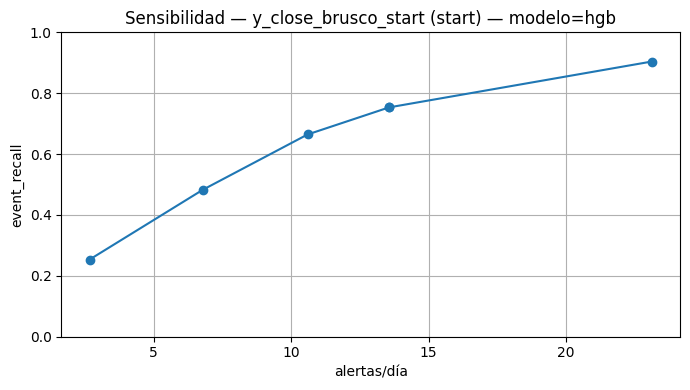

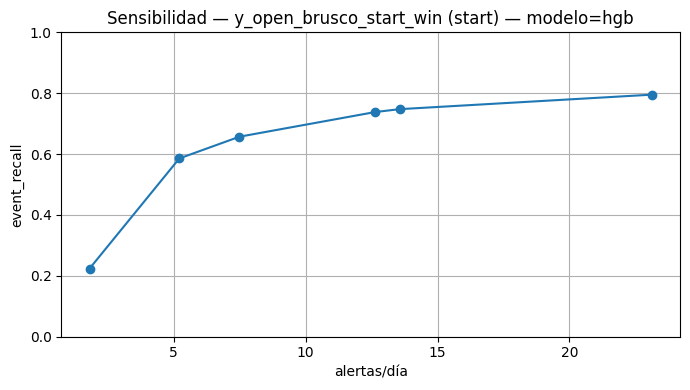

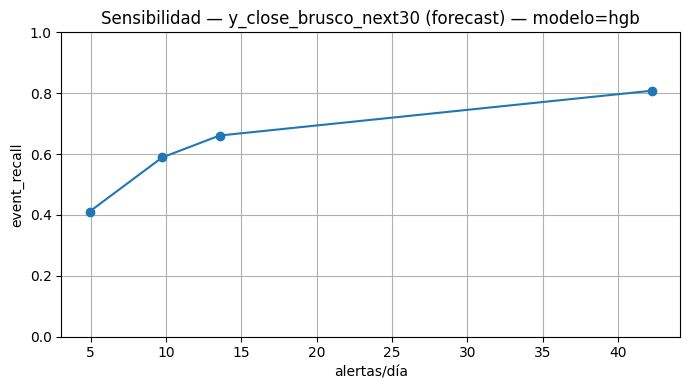

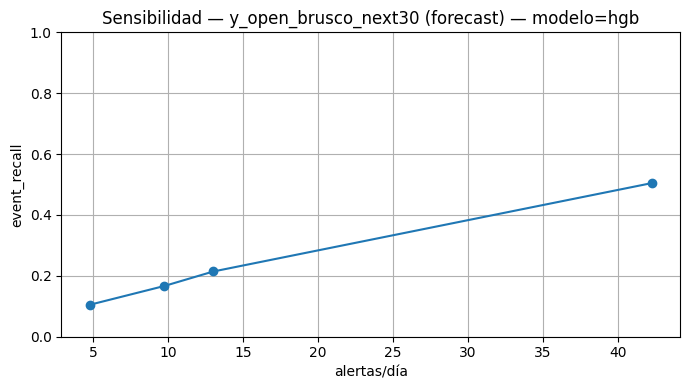

In [18]:
# Plot sensibilidad: recall vs alertas/día para targets seleccionados (HGB si existe)
if ml_sen is not None:
    sen = ml_sen.copy()

    def plot_sensitivity(target, model="hgb"):
        s = sen[(sen["target"]==target) & (sen["model"]==model)].copy()
        if len(s)==0:
            return
        # elegir eje según task
        task = s["task"].iloc[0]
        s = s.sort_values("alerts_per_day")
        plt.figure(figsize=(7,4))
        plt.plot(s["alerts_per_day"], s["event_recall"], marker="o")
        plt.ylim(0,1)
        plt.title(f"Sensibilidad — {target} ({task}) — modelo={model}")
        plt.xlabel("alertas/día")
        plt.ylabel("event_recall")
        plt.tight_layout()
        plt.show()

    for tgt in [t for t in ["y_close_brusco_start","y_open_brusco_start_win","y_close_brusco_next30","y_open_brusco_next30"] if t in sen["target"].unique()]:
        plot_sensitivity(tgt, model="hgb")


### 6.4 Modelo recomendado (y por qué)

La selección se basa en el reporte bajo una política explícita de presupuesto:

- **Detección (start):** interesa maximizar `event_recall` con una tasa de falsas alarmas aceptable (FP/day).
- **Forecast:** interesa anticipación por evento con una tasa de alarmas/día acotada.

**Recomendación práctica (según el reporte y la política usada):**
- Para **cierres** y **cierres bruscos**: preferir **HistGradientBoosting (HGB)** cuando entrega mejor o comparable recall con umbral operativo estable.
- Para **aperturas**: usar targets con ventana (*start_win*) y comparar HGB vs LogReg; si el desempeño es similar, LogReg puede ser preferible por interpretabilidad y estabilidad (coeficientes).

> Nota: esta recomendación es condicional a los presupuestos adoptados (FP/day y alertas/día).
> Al variar el presupuesto, el umbral óptimo y el modelo “ganador” pueden cambiar (ver sensibilidad).


In [19]:
# Tabla final: modelo recomendado por target (según best bajo política)
best_view = best.copy()
best_view = best_view.sort_values(["task","target"])
best_view[["task","target","model","event_recall","alerts_per_day","AP(PR-AUC)"]]


,task,target,model,event_recall,alerts_per_day,AP(PR-AUC)
0,forecast,y_close_brusco_next10,logreg,0.945205,42.245614,0.365955
1,forecast,y_close_brusco_next30,logreg,0.907534,42.245614,0.443402
2,forecast,y_close_brusco_next60,logreg,0.753425,42.245614,0.586458
3,forecast,y_open_brusco_next10,hgb,0.352381,42.245614,0.169779
4,forecast,y_open_brusco_next30,hgb,0.504762,42.245614,0.364528
5,forecast,y_open_brusco_next60,hgb,0.490476,42.245614,0.514139
6,start,y_close_brusco_start,hgb,0.753425,13.561404,0.345229
7,start,y_close_start,hgb,0.735974,13.350877,0.352762
8,start,y_open_brusco_start_win,logreg,0.809524,12.315789,0.160075
9,start,y_open_start_win,hgb,0.810185,13.561404,0.182125


## 7) Limitaciones y recomendaciones

### Limitaciones principales
1. $\Delta t\approx 1$ min no permite medir el pico real de transientes (segundos).
2. Un solo punto de sensor limita localización de singularidades y diagnóstico causal.
3. Screening de cavitación en el sensor no descarta cavitación local aguas arriba/abajo.
4. Etiquetas “brusco” dependen de definición operacional (bins/umbrales).

### Recomendaciones
- Instrumentación de presión a mayor frecuencia (≥ 1 Hz, ideal 10–100 Hz) para capturar transientes reales.
- Sensor adicional aguas arriba/abajo para inferir propagación y ubicar eventos.
- Registro de maniobras de válvulas/bombas para explicar anomalías.
- En ML: calibración de probabilidades, validación cruzada temporal y enriquecimiento de features con variables de estado de red.


## 8) Conclusiones finales

1. **Cavitación:** no hay evidencia termodinámica directa de cavitación en el punto de sensor ($P_{\mathrm{abs}}<P_v$ no ocurre en la serie), aunque no se descarta cavitación local o mínimos instantáneos submuestreados.
2. **Eventos dominantes:** la operación se organiza en aperturas y cierres; a escala minuto, la mayoría cae en bins 0–4 min, indicando transiciones rápidas respecto de la grilla.
3. **Persistencia:** cierres tienden a ser más “persistentes” (nuevo régimen) y aperturas más “pulso”, coherente con demanda.
4. **Severidad:** existen eventos extremos de $\Delta Q$ y $\Delta P$ (proxy a 1 min) que justifican inspección focalizada (especialmente los anómalos por Isolation Forest).
5. **ML:** la detección/forecast es viable como herramienta operacional bajo presupuestos explícitos de alarmas:
   - cierres bruscos resultan más anticipables que aperturas bruscas en horizontes cortos,
   - la selección de umbral y modelo debe comunicarse como trade-off (sensibilidad).

---

### Exportación/artefactos
Este notebook no modifica datos; utiliza los parquet ya generados en 02–05.


## Apéndice — Resumen automático de archivos usados

In [20]:
print("=== ARCHIVOS ===")
for p in [SENS_FILE, EVENTS_FILE, HORIZ_FILE, IF_LABELED, IF_ANOMS, ML_REPORT, ML_SENSIT]:
    print(f"{p.name:40s} exists={p.exists()}  path={p}")
print("=== FIN ===")


=== ARCHIVOS ===
sensores_1min_clean.parquet              exists=True  path=/home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet
eventos_apertura_cierre.parquet          exists=True  path=/home/maxi/datascience_esval/data/processed/eventos_apertura_cierre.parquet
eventos_apertura_cierre_horizontes.parquet exists=True  path=/home/maxi/datascience_esval/data/processed/eventos_apertura_cierre_horizontes.parquet
eventos_iforest_labeled.parquet          exists=True  path=/home/maxi/datascience_esval/data/processed/eventos_iforest_labeled.parquet
iforest_anomalias.parquet                exists=True  path=/home/maxi/datascience_esval/data/processed/iforest_anomalias.parquet
ml_report_metrics.parquet                exists=True  path=/home/maxi/datascience_esval/data/processed/ml_report_metrics.parquet
ml_sensitivity_budgets.parquet           exists=True  path=/home/maxi/datascience_esval/data/processed/ml_sensitivity_budgets.parquet
=== FIN ===
